# Best practices

In this notebook we go through some more opinionated best practices, if starting a project from scratch this may be informative for setting things up to be probabilistic.

## Line fitting

 This minimal example demonstrates Bayesian parameter estimation for a simple linear model using adaptive nested sampling. Synthetic data is generated from a linear model with parameters for slope, intercept, and noise level. The example sets up the likelihood and uniform priors, samples the posterior using blackJAX's nested sampling routine, and finally post-processes the samples with the `anesthetic` package for in-depth visualization and analysis.

## Installation

In [1]:
!pip install -q git+https://github.com/handley-lab/blackjax anesthetic tqdm

In [2]:
import jax
import jax.numpy as jnp
import tqdm
import blackjax

jax.config.update("jax_enable_x64", True)

## 0. Nested Sampling parameters
 
 - `num_dims` is the number of parameters you are fitting for
 - `num_live` is a resolution parameter. evidence and posteriors get better as sqrt(nlive), runtime increases linearly with num_live 
 - `num_inner_steps` is a reliability parameter. Setting this too low degrades results, but there is no gain to arbitrarily increasing it. Best practice is to check that halving or doubling it doesn't change the results. runtime increases linearly with num_inner_steps
 - `num_delete` is a parallelisation parameter. You shouldn't need to change this.

In [3]:
rng_key = jax.random.PRNGKey(0)
num_dims = 3
num_live = 1000
num_inner_steps = num_dims * 5
num_delete = num_live // 2

## 1. Define data and likelihood
 
 This problem consists of fitting a `y=mx+c` model to data, where the gradient `m`, intercept `c` and noise level `sigma` are to be fitted for from a set of (x, y) data points.
 In this instance the true model has $m=2, c=1, \sigma=1$.

In [4]:
num_data = 10
xmin, xmax = -1.0, 1.0
x = jnp.linspace(xmin, xmax, num_data)
m = 2.0
c = 1.0
sigma = 1
key, rng_key = jax.random.split(rng_key)
noise = sigma * jax.random.normal(key, (num_data,)) 
y = m * x + c + noise

Easiest just to plot the data to see.

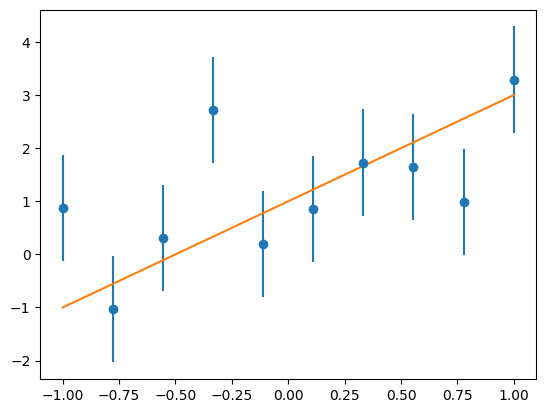

In [5]:
import matplotlib.pyplot as plt

plt.errorbar(x, y, yerr=sigma, fmt="o", label="data")
plt.plot(x, m * x + c, label="true model");

## Structured Prior Models

BlackJAX's nested sampling implementation encourages the use of structured parameter spaces through dictionaries (PyTrees). This is the **recommended pattern** for several important reasons:

1. **Parameter naming**: Clear, semantic names for each parameter make your model self-documenting
2. **Heterogeneous types**: Different parameters can have different shapes and structures  
3. **JAX compatibility**: Dictionary structures are first-class PyTrees in JAX, enabling automatic differentiation and vectorization
4. **Extensibility**: Adding new parameters is as simple as adding a new dictionary key

In this example we'll use a dictionary with keys `"m"`, `"c"`, and `"sigma"` rather than a flat array like `params[0]`, `params[1]`, `params[2]`. This structured approach:
- Makes the likelihood function readable: `params["m"]` vs `params[0]`
- Simplifies prior specification with per-parameter bounds
- Enables easy parameter transformations and constraints
- Facilitates integration with other probabilistic programming tools

The `blackjax.ns.utils.uniform_prior` helper we'll use later automatically creates this structured format from a bounds dictionary.

## 2. Define the likelihood function

 Here we just make use of the `scipy` multivariate normal distribution to define the likelihood function, which is normal in the data.

In [6]:
def loglikelihood_fn(params):
    m = params["m"]
    c = params["c"]
    sigma = params["sigma"]
    cov = sigma ** 2
    return jax.scipy.stats.multivariate_normal.logpdf(y, m * x + c, cov)

## 3. Define the prior function

 Here we use uniform priors for the parameters.

In [7]:
prior_bounds = {
        "m": (-5.0, 5.0),
        "c": (-5.0, 5.0),
        "sigma": (0.0, 10.0),
        }

rng_key, prior_key = jax.random.split(rng_key)
particles, logprior_fn = blackjax.ns.utils.uniform_prior(prior_key, num_live, prior_bounds)

In [8]:
print(f"Particle structure: {particles.keys()}")
print(f"Shape of each parameter: {particles['m'].shape}")
print(f"First few samples of 'm': {particles['m'][:3]}")

Particle structure: dict_keys(['c', 'm', 'sigma'])
Shape of each parameter: (1000,)
First few samples of 'm': [-0.46275406 -1.23704798  3.88207402]


As you can see, `particles` is a dictionary where each key corresponds to a parameter, and the values are arrays of shape `(num_live,)` containing the initial samples for that parameter. This structure propagates through the entire nested sampling run, making it easy to track and analyze individual parameters throughout the algorithm.

## 4. Run Nested Sampling

In [9]:
nested_sampler = blackjax.nss(
    logprior_fn=logprior_fn,
    loglikelihood_fn=loglikelihood_fn,
    num_delete=num_delete,
    num_inner_steps=num_inner_steps,
)
init_fn = jax.jit(nested_sampler.init)
step_fn = jax.jit(nested_sampler.step)

live = init_fn(particles)
dead = []
with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not live.logZ_live - live.logZ < -3:
        rng_key, subkey = jax.random.split(rng_key, 2)
        live, dead_info = step_fn(subkey, live)
        dead.append(dead_info)
        pbar.update(num_delete)

dead = blackjax.ns.utils.finalise(live, dead)

Dead points: 0 dead points [00:00, ? dead points/s]

Dead points: 500 dead points [00:03, 158.85 dead points/s]

Dead points: 5000 dead points [00:03, 2095.77 dead points/s]

Dead points: 7500 dead points [00:03, 2256.81 dead points/s]

## 5. Save the data as a csv

 This uses the anesthetic tool, a nested sampler agnostic software package for processing and plotting nested sampling results (think getdist, arviz, corner.py, but specialised for nested sampling). 

 You may prefer other posterior plotting packages, but should be aware of this for the nested sampling specific pieces, including but not limited to:
 - `samples.logZ()` - the log evidence
 - `samples.logZ(n)` - samples from the evidence distribution
 - `samples.gui()` - a GUI for exploring the nested sampling run
    - also accessible as an executable `anesthetic line.csv` if you've saved the samples.
 - `samples.prior()` - the prior samples
 - `samples.live_points(i)` - the live points at any point in the run

In [10]:
from anesthetic import NestedSamples
columns = ["m", "c", "sigma"]
labels = [r"$m$", r"$c$", r"$\sigma$"]
data = jnp.vstack([dead.particles[key] for key in columns]).T
samples = NestedSamples(
    data,
    logL=dead.loglikelihood,
    logL_birth=dead.loglikelihood_birth,
    columns=columns,
    labels=labels,
    logzero=jnp.nan,
)
samples.to_csv("line.csv")

## 7. Plot results

 The rest of this script showcases nested sampling plotting and analysis capabilities

load results from file if you're returning to this script later

In [11]:
from anesthetic import read_chains
samples = read_chains("line.csv")

### Plot the posterior with anesthetic

 For more detail have a look at 
 https://anesthetic.readthedocs.io/en/latest/plotting.html

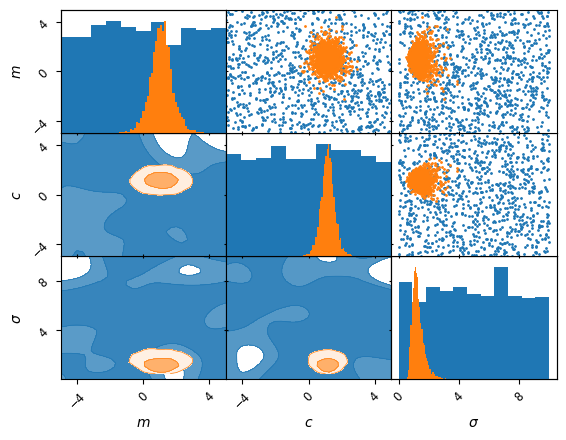

In [12]:
kinds ={'lower': 'kde_2d', 'diagonal': 'hist_1d', 'upper': 'scatter_2d'}
axes = samples.prior().plot_2d(['m', 'c', 'sigma'], kinds=kinds, label='prior')
samples.plot_2d(axes, kinds=kinds, label='posterior');

Plot the functional posterior

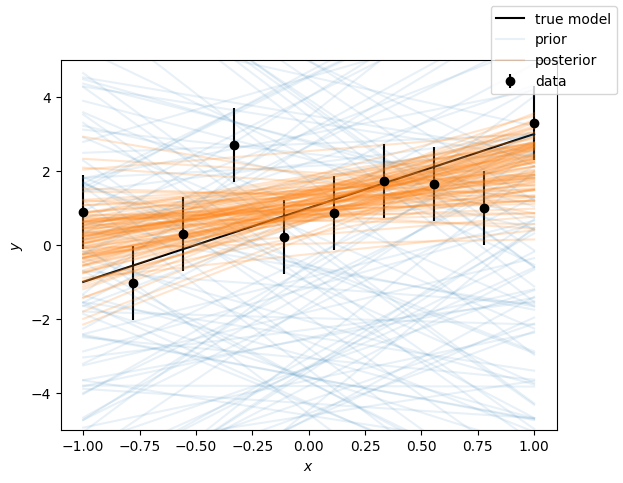

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Plot the data
ax.errorbar(x, y, yerr=sigma, fmt="o", label="data", color='k')
ax.plot(x, m * x + c, label="true model", color='k');

# Get samples from the function y=mx+c
m_ = samples.m.values[:, None]
c_ = samples.c.values[:, None]
y_ = m_ * x  + c_
yvals = [f'y_{i}' for i in range(num_data)]
samples[yvals] = y_

# Plot the prior and posterior function samples
lines = ax.plot(x, samples.prior()[yvals].sample(100).T, color="C0", alpha=0.1)
lines[0].set_label("prior")
lines = ax.plot(x, samples[yvals].sample(100).T, color="C1", alpha=0.2)
lines[0].set_label("posterior")

# tidy up
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_ylim(-5, 5)
fig.legend();